In [1]:
import time
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.neighbors import NearestNeighbors

import math



#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## 2.Récupération et analyse du jeu de données

In [2]:
doc=pd.read_csv('jena_climate_2009_2016.csv')
print(doc)

                  Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:00:00    996.50     -8.00    264.76        -8.92   
1       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
2       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
3       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
4       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
...                     ...       ...       ...       ...          ...   
420547  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420548  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420549  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420550  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420551  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0        93.30          3.33          3.

In [3]:
#TODO enlever les données abbérantes 

In [4]:
print(doc.info())
print(doc.shape)
print(doc.head())
print(doc.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420552 entries, 0 to 420551
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420552 non-null  object 
 1   p (mbar)         420552 non-null  float64
 2   T (degC)         420552 non-null  float64
 3   Tpot (K)         420552 non-null  float64
 4   Tdew (degC)      420552 non-null  float64
 5   rh (%)           420552 non-null  float64
 6   VPmax (mbar)     420552 non-null  float64
 7   VPact (mbar)     420552 non-null  float64
 8   VPdef (mbar)     420552 non-null  float64
 9   sh (g/kg)        420552 non-null  float64
 10  H2OC (mmol/mol)  420552 non-null  float64
 11  rho (g/m**3)     420552 non-null  float64
 12  wv (m/s)         420552 non-null  float64
 13  max. wv (m/s)    420552 non-null  float64
 14  wd (deg)         420552 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB
None
(420552, 15)
             Date 

## 3.Préparation et transformation du jeu de données

In [5]:
doc['Date Time'] = pd.to_datetime(doc['Date Time'], format="%d.%m.%Y %H:%M:%S")

In [6]:
doc.set_index("Date Time", inplace=True)

In [7]:
print(doc.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420552 entries, 2009-01-01 00:00:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420552 non-null  float64
 1   T (degC)         420552 non-null  float64
 2   Tpot (K)         420552 non-null  float64
 3   Tdew (degC)      420552 non-null  float64
 4   rh (%)           420552 non-null  float64
 5   VPmax (mbar)     420552 non-null  float64
 6   VPact (mbar)     420552 non-null  float64
 7   VPdef (mbar)     420552 non-null  float64
 8   sh (g/kg)        420552 non-null  float64
 9   H2OC (mmol/mol)  420552 non-null  float64
 10  rho (g/m**3)     420552 non-null  float64
 11  wv (m/s)         420552 non-null  float64
 12  max. wv (m/s)    420552 non-null  float64
 13  wd (deg)         420552 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB
None


In [8]:
print(doc)

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:00:00    996.50     -8.00    264.76        -8.92   93.30   
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90   93.30   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28   93.40   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31   93.90   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07   94.20   
...                       ...       ...       ...          ...     ...   
2016-12-31 23:20:00   1000.07     -4.05    269.10        -8.13   73.10   
2016-12-31 23:30:00    999.93     -3.35    269.81        -8.06   69.71   
2016-12-31 23:40:00    999.82     -3.16    270.01        -8.21   67.91   
2016-12-31 23:50:00    999.81     -4.23    268.94        -8.53   71.80   
2017-01-01 00:00:00    999.82     -4.82    268.36        -8.42   75.70   

                     VPmax (mbar)  VP

In [9]:
#Normalisation Min-Max : Nouvelle valeur = (valeur – min) / (max – min)
#Normalisation moyenne : Nouvelle valeur = (valeur – moyenne) / (écart type)

#Min-max : 
doc_normalisé=(doc-doc.min())/(doc.max()-doc.min())
print(doc_normalisé)

#moyenne :
#(doc-doc.mean())/doc.std()
#print(doc)

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
Date Time                                                                  
2009-01-01 00:00:00  0.814742  0.248963  0.233125     0.334372  0.923033   
2009-01-01 00:10:00  0.814939  0.248632  0.243662     0.334788  0.923033   
2009-01-01 00:20:00  0.815430  0.242163  0.237241     0.326891  0.924182   
2009-01-01 00:30:00  0.815037  0.240504  0.235594     0.326268  0.929925   
2009-01-01 00:40:00  0.814840  0.243822  0.239052     0.331255  0.933372   
...                       ...       ...       ...          ...       ...   
2016-12-31 23:20:00  0.849828  0.314480  0.304577     0.350790  0.690982   
2016-12-31 23:30:00  0.848452  0.326091  0.316266     0.352244  0.652039   
2016-12-31 23:40:00  0.847371  0.329242  0.319559     0.349127  0.631361   
2016-12-31 23:50:00  0.847273  0.311494  0.301943     0.342477  0.676048   
2017-01-01 00:00:00  0.847371  0.301708  0.292394     0.344763  0.720850   

           

In [10]:
doc_aggrege = doc_normalisé.resample('2H').mean()
doc_aggrege = doc_aggrege.reset_index()
print(doc_aggrege)
print(doc_aggrege.shape)

                Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0     2009-01-01 00:00:00  0.814980  0.246323  0.240533     0.333247   
1     2009-01-01 02:00:00  0.818337  0.235197  0.229969     0.318198   
2     2009-01-01 04:00:00  0.822940  0.223545  0.217786     0.300966   
3     2009-01-01 06:00:00  0.832629  0.233690  0.226635     0.314647   
4     2009-01-01 08:00:00  0.845430  0.254561  0.245719     0.338927   
...                   ...       ...       ...       ...          ...   
35060 2016-12-31 16:00:00  0.873645  0.404890  0.391272     0.424979   
35061 2016-12-31 18:00:00  0.870106  0.362595  0.349742     0.402224   
35062 2016-12-31 20:00:00  0.861294  0.338890  0.327406     0.374325   
35063 2016-12-31 22:00:00  0.851613  0.321115  0.311011     0.358583   
35064 2017-01-01 00:00:00  0.847371  0.301708  0.292394     0.344763   

         rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0      0.928968      0.037369      0.083697      0.004437   0.0

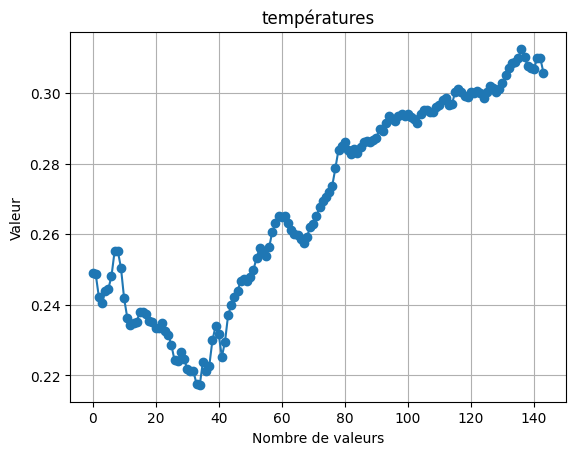

In [11]:
donnees_a_tracer = doc_normalisé['T (degC)'].head(144)

x_values = range(144)

plt.plot(x_values, donnees_a_tracer, marker='o', linestyle='-')
plt.xlabel('Nombre de valeurs')
plt.ylabel('Valeur')
plt.title('températures')
plt.grid(True)

plt.show()

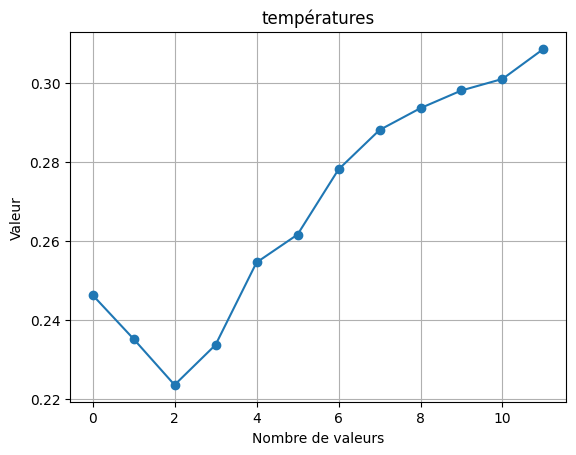

In [12]:
donnees_a_tracer_2 = doc_aggrege['T (degC)'].head(12)

x_values_2 = range(12)

plt.plot(x_values_2, donnees_a_tracer_2, marker='o', linestyle='-')
plt.xlabel('Nombre de valeurs')
plt.ylabel('Valeur')
plt.title('températures')
plt.grid(True)

plt.show()

## 4.Extraction des caractéristiques

In [13]:
def vecteur(df_jour,indice_ligne1,tableau_jour):
    name_col=['p (mbar)','T (degC)','rh (%)','VPact (mbar)','H2OC (mmol/mol)','wv (m/s)']
    vect=[]
    
    tableau_jour.append(df_jour.loc[indice_ligne1,'Date Time'].date())

    for el in name_col:
        for i in range (indice_ligne1,indice_ligne1+12,1):
            vect.append(df_jour.loc[i,el])
        
    return vect

In [14]:
nb_jours=int(doc_aggrege.shape[0]/12)
tableau_jour=[]
matrice_stockee=np.array([vecteur(doc_aggrege.iloc[12*i:12*(i+1)],i*12,tableau_jour) for i in range(nb_jours)])

In [15]:
np.save("matrice_vecteurs",matrice_stockee)

In [16]:
print(matrice_stockee.shape)

(2922, 72)


In [17]:
print(tableau_jour)
print(len(tableau_jour))

[datetime.date(2009, 1, 1), datetime.date(2009, 1, 2), datetime.date(2009, 1, 3), datetime.date(2009, 1, 4), datetime.date(2009, 1, 5), datetime.date(2009, 1, 6), datetime.date(2009, 1, 7), datetime.date(2009, 1, 8), datetime.date(2009, 1, 9), datetime.date(2009, 1, 10), datetime.date(2009, 1, 11), datetime.date(2009, 1, 12), datetime.date(2009, 1, 13), datetime.date(2009, 1, 14), datetime.date(2009, 1, 15), datetime.date(2009, 1, 16), datetime.date(2009, 1, 17), datetime.date(2009, 1, 18), datetime.date(2009, 1, 19), datetime.date(2009, 1, 20), datetime.date(2009, 1, 21), datetime.date(2009, 1, 22), datetime.date(2009, 1, 23), datetime.date(2009, 1, 24), datetime.date(2009, 1, 25), datetime.date(2009, 1, 26), datetime.date(2009, 1, 27), datetime.date(2009, 1, 28), datetime.date(2009, 1, 29), datetime.date(2009, 1, 30), datetime.date(2009, 1, 31), datetime.date(2009, 2, 1), datetime.date(2009, 2, 2), datetime.date(2009, 2, 3), datetime.date(2009, 2, 4), datetime.date(2009, 2, 5), datet

## 5.Recherche par similarité

#### 5.1.Méthode exacte

In [18]:
from sklearn.neighbors import NearestNeighbors

In [19]:
k = 5
plus_proches_voisins = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')


In [20]:
donnees_entrainement = matrice_stockee[:2922-100]
donnees_entrainement = pd.DataFrame(donnees_entrainement)
#print(donnees_entrainement)
#plus_proches_voisins.fit(donnees_entrainement)

#erreur:Input contains NaN, infinity or a value too large for dtype('float64').
#Il y a des NaN dans la DataFrame

In [21]:
valeurs_manquantes = donnees_entrainement.isna()
#return True s'il y a des NaN dans la DataFrame
au_moins_une_valeur_manquante = valeurs_manquantes.any().any()
#somme des NaN par colonne
somme_valeurs_manquantes_par_colonne = valeurs_manquantes.sum()
print(somme_valeurs_manquantes_par_colonne)
print(au_moins_une_valeur_manquante)

#Il y a bien des NaN, il faut les remplacer

0     1
1     1
2     1
3     1
4     0
     ..
67    0
68    0
69    1
70    1
71    1
Length: 72, dtype: int64
True


In [22]:
# On remplace les NaN par la moyenne de chaque colonne
donnees_entrainement_sans_nan = donnees_entrainement.fillna(donnees_entrainement.mean())
plus_proches_voisins.fit(donnees_entrainement_sans_nan)

NearestNeighbors(algorithm='brute', metric='euclidean')

In [30]:
requetes = matrice_stockee[-100:]
requetes = pd.DataFrame(requetes)
requetes_sans_nan = requetes.fillna(requetes.mean())


100


In [45]:
nombre_de_requetes = requetes_sans_nan.shape[0]
indices_voisins = []
distances_voisins = []
dates_voisins=[]
for i in range(nombre_de_requetes):
    requete_actuelle = requetes_sans_nan.iloc[i].values.reshape(1, -1)  
    distances, indices = plus_proches_voisins.kneighbors(requete_actuelle, n_neighbors=k)
    indices_voisins.append(indices[0])
    voisins=[]
    for el in indices[0]:
        voisins.append(tableau_jour[el])
    dates_voisins.append(voisins)
    distances_voisins.append(distances)
print(indices_voisins)
print(distances_voisins)
print(dates_voisins)

[array([ 249, 1004,  233, 1585, 1354], dtype=int64), array([1340, 1003,  628, 1005, 1388], dtype=int64), array([ 249, 1004, 1354,  121,  167], dtype=int64), array([1939, 2071, 2703, 2069,  644], dtype=int64), array([ 264,  617, 1000, 2095, 2100], dtype=int64), array([ 265, 1341, 1340, 1342,  870], dtype=int64), array([2802, 2367, 1642, 1633, 2370], dtype=int64), array([1013, 1259,  271, 1757, 2060], dtype=int64), array([1943,  914, 1717, 2063,  257], dtype=int64), array([ 932,   97, 1360,  607, 2380], dtype=int64), array([1582,  299,  130, 1154, 1032], dtype=int64), array([2459,  881,  267,  108, 2440], dtype=int64), array([1165, 2552, 1166, 1167, 1089], dtype=int64), array([2483, 1392, 1390, 1014,  503], dtype=int64), array([ 636, 2484, 2121, 1613, 1014], dtype=int64), array([2484, 2121,  636, 2123,  301], dtype=int64), array([1746, 1580, 2122, 1421,  112], dtype=int64), array([2540, 2482, 2481, 2484,  112], dtype=int64), array([2481, 2482, 2480, 2484, 1469], dtype=int64), array([2480

#### 5.2.Méthode approximative

In [25]:
from lsh import LSH

In [55]:
#vérité terrain

bf = NearestNeighbors(n_neighbors=1, algorithm='brute')
bf.fit(donnees_entrainement_sans_nan)
ground_results = bf.kneighbors(requetes_sans_nan, n_neighbors=1)
ground_indices=[]
date_voisin_pp=[]
for el in ground_results[1] : 
    indice=el[0]
    ground_indices.append(indice)
    date_voisin_pp.append(tableau_jour[indice])
print(ground_indices)
print(date_voisin_pp)


[249, 1340, 249, 1939, 264, 265, 2802, 1013, 1943, 932, 1582, 2459, 1165, 2483, 636, 2484, 1746, 2540, 2481, 2480, 2481, 2137, 1584, 2130, 1033, 2472, 743, 498, 60, 670, 670, 58, 636, 747, 747, 2488, 2551, 1464, 2580, 1177, 1578, 2151, 651, 1409, 310, 1839, 1470, 21, 1785, 344, 749, 1145, 751, 287, 1745, 671, 1767, 1455, 801, 329, 1751, 2481, 1040, 2165, 383, 2166, 1789, 751, 1112, 1802, 2167, 2168, 1, 45, 2576, 1791, 2631, 1463, 281, 1407, 73, 1052, 1468, 2626, 1790, 1791, 2191, 2264, 1119, 1790, 2168, 1780, 1802, 1406, 744, 1105, 1090, 2239, 1797, 792]
[datetime.date(2009, 9, 7), datetime.date(2012, 9, 2), datetime.date(2009, 9, 7), datetime.date(2014, 4, 24), datetime.date(2009, 9, 22), datetime.date(2009, 9, 23), datetime.date(2016, 9, 3), datetime.date(2011, 10, 11), datetime.date(2014, 4, 28), datetime.date(2011, 7, 22), datetime.date(2013, 5, 2), datetime.date(2015, 9, 26), datetime.date(2012, 3, 11), datetime.date(2015, 10, 20), datetime.date(2010, 9, 29), datetime.date(2015, 1

In [56]:
print(donnees_entrainement_sans_nan.to_numpy())

[[0.81497952 0.81833743 0.82294021 ... 0.99720984 0.9972164  0.99720094]
 [0.84283374 0.83625717 0.83062244 ... 0.99744702 0.9974545  0.9973399 ]
 [0.87244881 0.87060606 0.86556921 ... 0.99732103 0.99726452 0.99729319]
 ...
 [0.77334971 0.76945946 0.76895987 ... 0.99723103 0.99721383 0.99719729]
 [0.7855774  0.78415233 0.78577396 ... 0.99721383 0.99722903 0.99725014]
 [0.79992629 0.80183456 0.80235872 ... 0.99722912 0.99729668 0.99725214]]


In [66]:
# Infuence du facteur W

w_values = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
precisions = []
inspected_avgs = []
donnees_entrainement_sans_nan_numpy=donnees_entrainement_sans_nan.to_numpy()
requetes_sans_nan_numpy=requetes_sans_nan.to_numpy()
for w in w_values:
    print('Valeur de W:%f' % w)
    lsh = LSH(nb_projections=10, nb_tables=2, w=w)
    lsh.fit(donnees_entrainement_sans_nan_numpy)
    match_count = 0
    inspected_count = 0
    for i, query in enumerate(requetes_sans_nan_numpy):
        lsh_result = lsh.kneighbors(query, k=1)
        lsh_index = lsh_result[1][0]
        match_count += 1 if lsh_index == ground_indices[i] else 0
        inspected_count += lsh_result[2]

    precision = match_count / len(requetes_sans_nan)
    precisions.append(precision)
    print('precision: %f' % precision)

    inspected_avg = inspected_count / len(requetes_sans_nan)
    inspected_avgs.append(inspected_avg)
    print('inspected data: %f' % inspected_avg)

Valeur de W:0.250000
precision: 0.670000
inspected data: 126.890000
Valeur de W:0.500000
precision: 0.960000
inspected data: 660.290000
Valeur de W:0.750000
precision: 0.990000
inspected data: 1551.880000
Valeur de W:1.000000
precision: 0.940000
inspected data: 1492.550000
Valeur de W:1.250000
precision: 0.990000
inspected data: 1730.320000
Valeur de W:1.500000
precision: 0.970000
inspected data: 1910.840000
Valeur de W:1.750000
precision: 0.990000
inspected data: 2020.690000
Valeur de W:2.000000
precision: 0.980000
inspected data: 2182.350000


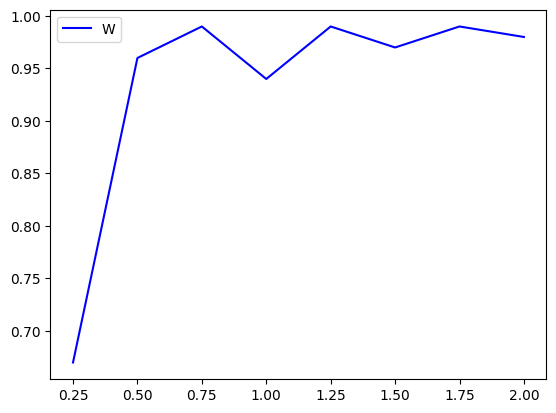

In [67]:
# courbe de la précision en fonction de W
plt.plot(w_values, precisions, label='W', color='blue')
plt.legend()
plt.show()

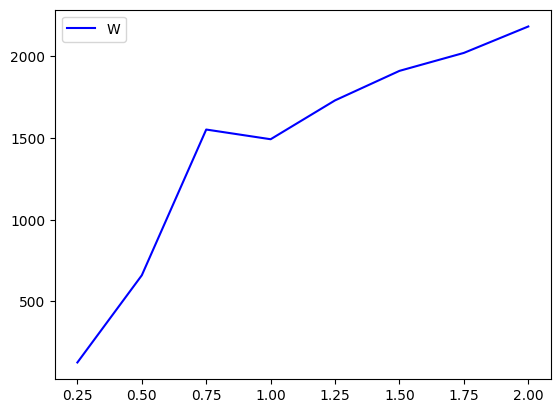

In [68]:
# courbe du nombre de données inspectés en moyenne en fonction de W
plt.plot(w_values, inspected_avgs, label='W', color='blue')
plt.legend()
plt.show()

In [69]:
# Infuence du nombre de table de hachage
precisions = []
ratio_avgs = []
data_size = len(donnees_entrainement_sans_nan)
for nt in range(1,7):
    print('Nombre de tables:%d' % nt)
    lsh = LSH(nb_projections=10, nb_tables=nt, w=1.0)
    lsh.fit(donnees_entrainement_sans_nan_numpy)
    match_count = 0
    inspected_count = 0
    ratio_sum = 0

    for i, query in enumerate(requetes_sans_nan_numpy):
        lsh_result = lsh.kneighbors(query, k=1)
        lsh_index = lsh_result[1][0]
        match_count += 1 if lsh_index == ground_indices[i] else 0
        inspected_count += lsh_result[2]
        ratio = inspected_count / data_size
        ratio_sum += ratio

    precision = match_count / len(requetes_sans_nan)
    precisions.append(precision)
    print('precision: %f' % precision)
    ratio_avg = ratio_sum / len(requetes_sans_nan)
    8
    ratio_avgs.append(ratio_avg)
    print('average ratio : %f' % ratio_avg)

Nombre de tables:1
precision: 0.910000
average ratio : 18.770656
Nombre de tables:2
precision: 0.940000
average ratio : 27.753476
Nombre de tables:3


c:\Users\amand\OneDrive\Documents\IMTne\cours CI2\ODATA\code\PROJET\lsh.py:50: RuntimeWarning: invalid value encountered in cast
  self._signature_projections = np.random.uniform(0, np.random.uniform(0, 2 << 32), (self._nb_projections,)).astype(np.int32)


precision: 1.000000
average ratio : 42.288455
Nombre de tables:4
precision: 1.000000
average ratio : 50.500000
Nombre de tables:5
precision: 1.000000
average ratio : 48.156545
Nombre de tables:6
precision: 1.000000
average ratio : 50.466251


In [73]:
# Comportement en fonction de la la dimension de la donnée
max_dim = donnees_entrainement_sans_nan.shape[1]
for dim in range(10, max_dim, 20):
    print('Dimension:%d' % dim)
    red_donnees_entrainement_sans_nan = donnees_entrainement_sans_nan_numpy[:, :dim]
    red_requetes_sans_nan = requetes_sans_nan_numpy[:, :dim]
    bf = NearestNeighbors(n_neighbors=1, algorithm='brute')
    bf.fit(red_donnees_entrainement_sans_nan)
    ground_results = bf.kneighbors(red_requetes_sans_nan, n_neighbors=1)
    ground_indices = ground_results[1]

    for nproj in [5, 8, 10]:
        print('Nombre de projection:%d' % nproj)
        lsh = LSH(nb_projections=nproj, nb_tables=2, w=1.0)
        lsh.fit(red_donnees_entrainement_sans_nan)
        match_count = 0

        for i, query in enumerate(red_requetes_sans_nan):
            lsh_result = lsh.kneighbors(query, k=1)
            lsh_index = lsh_result[1][0]
            match_count += 1 if lsh_index == ground_indices[i] else 0
        
        precision = match_count / len(red_requetes_sans_nan)
        print('precision: %f' % precision)


Dimension:10
Nombre de projection:5


c:\Users\amand\OneDrive\Documents\IMTne\cours CI2\ODATA\code\PROJET\lsh.py:50: RuntimeWarning: invalid value encountered in cast
  self._signature_projections = np.random.uniform(0, np.random.uniform(0, 2 << 32), (self._nb_projections,)).astype(np.int32)


precision: 1.000000
Nombre de projection:8
precision: 0.990000
Nombre de projection:10
precision: 1.000000
Dimension:30
Nombre de projection:5
precision: 1.000000
Nombre de projection:8


c:\Users\amand\OneDrive\Documents\IMTne\cours CI2\ODATA\code\PROJET\lsh.py:50: RuntimeWarning: invalid value encountered in cast
  self._signature_projections = np.random.uniform(0, np.random.uniform(0, 2 << 32), (self._nb_projections,)).astype(np.int32)


precision: 1.000000
Nombre de projection:10
precision: 1.000000
Dimension:50
Nombre de projection:5


c:\Users\amand\OneDrive\Documents\IMTne\cours CI2\ODATA\code\PROJET\lsh.py:50: RuntimeWarning: invalid value encountered in cast
  self._signature_projections = np.random.uniform(0, np.random.uniform(0, 2 << 32), (self._nb_projections,)).astype(np.int32)


precision: 1.000000
Nombre de projection:8
precision: 1.000000
Nombre de projection:10
precision: 0.990000
Dimension:70
Nombre de projection:5


c:\Users\amand\OneDrive\Documents\IMTne\cours CI2\ODATA\code\PROJET\lsh.py:50: RuntimeWarning: invalid value encountered in cast
  self._signature_projections = np.random.uniform(0, np.random.uniform(0, 2 << 32), (self._nb_projections,)).astype(np.int32)


precision: 1.000000
Nombre de projection:8
precision: 1.000000
Nombre de projection:10
precision: 0.990000


## 6.Exploitation pratique des résultats de recherche